# Using `demes` for visualization and inference

Here, we'll get a handle on the `demes` demographic model specification format, look at a few models via `demesdraw`, and run a simple demographic inference using `moments.Demes`. First, let's just take a look at how demographic models are specified in `demes` and explore some visualizations.

In [1]:
import demes
import demesdraw
import matplotlib.pylab as plt

I won't go into much detail here about the `demes` spec - you should instead read through the documentation [here](https://popsim-consortium.github.io/demes-docs/main/index.html). This notebook will  assume you know the basics, so take at least a quick read over there. In short, a demes model includes demes (populations) and the relationships between them, which could be ancestors/descendants, migrations, or instantaneous admixture (pulses). A model is specified as a YAML file, and includes some extra basic information needed to describe the model.

In [2]:
from IPython.display import Markdown as md
# Function for printing syntax-highlighted YAML demes models
# If there is a better way to do this, tell me!!
def print_model(file_path):
    with open(file_path) as f:
        lines = f.read()
    return md("```yaml\n" + lines + "```")

## Zigzag model

As a quick example of a single-population demography, a zigzag or sawtooth model is a model in which the size alternates between exponential growth and decline. I copied this model from the `demes` examples directory.

In [3]:
zigzip_path = "../models/zigzag.yaml"
print_model(zigzip_path)

```yaml
description: A single population model with epochs of exponential growth and decay.
doi:
  - https://doi.org/10.1038/ng.3015
time_units: generations
generation_time: 30
demes: 
  - id: generic
    description: All epochs wrapped into the same population, so that epoch intervals
      do not overlap, and they tile the entire existence of the population (all time,
      in this case).
    epochs:
    - end_time: 34133.31
      start_size: 7156
    - end_time: 8533.33
      end_size: 71560
    - end_time: 2133.33
      end_size: 7156
    - end_time: 533.33
      end_size: 71560
    - end_time: 133.33
      end_size: 7156
    - end_time: 33.333
      end_size: 71560
    - end_time: 0
      end_size: 71560
```

`demes` loads in this YAML file and creates a graph object. This is just the specification of the demography. Other software can then take this graph representation of the demography and visualize it, simulate genetic data, run inference, etc.

In [4]:
zigzag = demes.load(zigzip_path)
zigzag.asdict()

{'description': 'A single population model with epochs of exponential growth and decay.',
 'time_units': 'generations',
 'generation_time': 30,
 'doi': ['https://doi.org/10.1038/ng.3015'],
 'demes': [{'id': 'generic',
   'description': 'All epochs wrapped into the same population, so that epoch intervals do not overlap, and they tile the entire existence of the population (all time, in this case).',
   'start_time': inf,
   'epochs': [{'end_time': 34133.31,
     'start_size': 7156,
     'end_size': 7156,
     'size_function': 'constant'},
    {'end_time': 8533.33,
     'start_size': 7156,
     'end_size': 71560,
     'size_function': 'exponential'},
    {'end_time': 2133.33,
     'start_size': 71560,
     'end_size': 7156,
     'size_function': 'exponential'},
    {'end_time': 533.33,
     'start_size': 7156,
     'end_size': 71560,
     'size_function': 'exponential'},
    {'end_time': 133.33,
     'start_size': 71560,
     'end_size': 7156,
     'size_function': 'exponential'},
    {

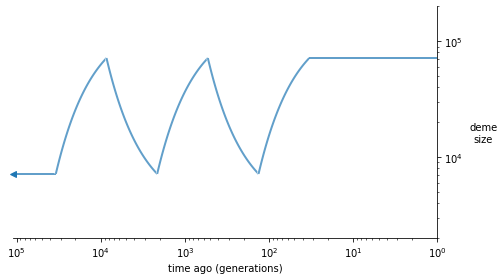

In [5]:
ax = demesdraw.size_history(zigzag, invert_x=True, log_time=True, log_size=True);
ax.set_ylim(2e3, 2e5);

We can use `moments` to compute the site frequency spectrum (SFS) under this demography. If you're not familiar with the SFS or `moments`, take some time to read through the documentation over [here](https://moments.readthedocs.org), particularly the SFS sections and "Specifying models with demes".

Let's compute the SFS under this demography and then compare it to the "standard neutral model", which is the expected SFS under a history with no size changes. To compute using a demes file or graph object, we pass the demography and lists of the sampled demes and sample sizes to `moments.Spectrum.from_demes`, which returns a frequency spectrum object. The SNM model can be computed from `moments.Demographics1D.snm`, which takes the sample size as the input.

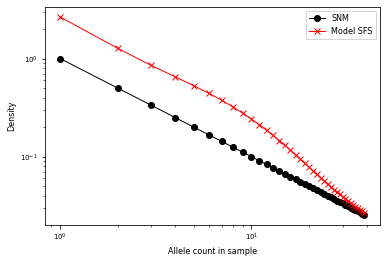

In [6]:
import moments
fs = moments.Spectrum.from_demes(zigzag, ["generic"], [40])
snm = moments.Demographics1D.snm([40])

ax = plt.subplot(111)
ax.plot(snm, "ko-", ms=6, lw=1, mfc=None, label="SNM")
ax.plot(fs, "rx-", ms=6, lw=1, label="Model SFS")
ax.legend();
ax.set_yscale("log");
ax.set_xscale("log");
ax.set_ylabel("Density");
ax.set_xlabel("Allele count in sample");

## Multipopulation human demography

A very well-known and widely-cited model of human history is the Out-of-Africa model, which describes how modern humans expanded within Africa and then diverged, with Eurasian populations experiencing the out-of-Africa bottleneck, and then subsequently diverging into continental populations. It is a very simple model, but is meant to capture basic patterns of genetic diversity within and between continental populations.

In [7]:
ooa_path = "../models/jouganous_ooa.yaml"
print_model(ooa_path)

```yaml
description: The Jouganous et al. (2017) OOA model.
doi:
- https://doi.org/10.1534/genetics.117.200493
time_units: years
generation_time: 29

demes:
- id: ancestral
  description: Equilibrium/root population
  epochs:
  - {end_time: 312e3, start_size: 11273}
- id: AMH
  description: Anatomically modern humans
  ancestors: [ancestral]
  epochs:
  - {end_time: 125e3, start_size: 23721}
- id: OOA
  description: Bottleneck out-of-Africa population
  ancestors: [AMH]
  epochs:
  - {end_time: 42.3e3, start_size: 3104}
- id: YRI
  description: Yoruba in Ibadan, Nigeria
  ancestors: [AMH]
  epochs:
  - start_size: 23721
- id: CEU
  description: Utah Residents (CEPH) with Northern and Western European Ancestry
  ancestors: [OOA]
  epochs:
  - {start_size: 2271, end_size: 39611}
- id: CHB
  description: Han Chinese in Beijing, China
  ancestors: [OOA]
  epochs:
  - {start_size: 924, end_size: 83771}

migrations:
- {demes: [YRI, OOA], rate: 15.8e-5}
- {demes: [YRI, CEU], rate: 1.10e-5}
- {demes: [YRI, CHB], rate: 0.48e-5}
- {demes: [CEU, CHB], rate: 4.19e-5}
```

Migration rates are given in units of per-generation probability of migrants moving between demes. More concretely, it's the probability that an individual in one deme had one of its parent from a different deme.

We can again use `demesdraw` to plot a schematic of this model:

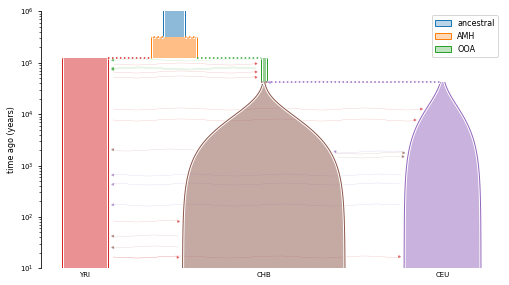

In [8]:
ooa = demes.load(ooa_path)
ax = demesdraw.tubes(ooa, num_lines_per_migration=3, log_time=True, seed=3, labels="xticks-legend");
ax.set_ylim(10, 1e6);

## Including Native Mexicans and MXL

The standard OOA model includes an African population (YRI are often used), a European population (CEU), and an East Asian (CHB) population. To include indigenous and admixed populations in this model, we can imagine a scenario where Native Mexicans diverge from East Asians 20 or 25 thousand years ago, experience a bottleneck corresponding to the crossing of the Bering Strait, and then a much more recent admixture event between Native Mexicans, Europeans, and Africans that results in the admixed MXL population.

I implemented a (non-inferred) demographic model for this scenario:

In [9]:
mxl_path = "../models/MXL_admixture_example.yaml"
mxl = demes.load(mxl_path)
print_model(mxl_path)

```yaml
description: Initial/approximate model for recent admixture between Afr, Eur,
  and Nat populations for the MXL population.
time_units: years
generation_time: 29
demes:
- id: ancestral
  description: Root population
  epochs:
  - end_time: 300000
    start_size: 10000
- id: AMH
  description: Anatomically modern humans
  ancestors: [ancestral]
  epochs:
  - end_time: 80000
    start_size: 20000
- id: OOA
  description: Bottleneck out-of-Africa population
  ancestors: [AMH]
  epochs:
  - end_time: 40000
    start_size: 2000
- id: YRI
  description: African population, with recent exponential expansion
  ancestors: [AMH]
  epochs:
  - end_time: 10000
    start_size: 20000
  - end_time: 0
    end_size: 100000
- id: CEU
  description: European population
  ancestors: [OOA]
  epochs:
  - end_time: 0
    start_size: 2000
    end_size: 50000
- id: CHB
  description: East Asian population
  ancestors: [OOA]
  epochs:
  - end_time: 0
    start_size: 100
    end_size: 80000
- id: NAT
  description: Native Mexican population
  ancestors: [CHB]
  start_time: 20000
  epochs:
  - end_time: 10000
    start_size: 1000
  - end_time: 400
    end_size: 50000
  - end_time: 0
    end_size: 2000
- id: MXL
  description: Admixed Mexican population
  ancestors: [NAT, CEU, YRI]
  proportions: [0.5, 0.4, 0.1]
  start_time: 400
  epochs:
  - end_time: 0
    start_size: 20000
    end_size: 50000
migrations:
- demes: [YRI, OOA]
  rate: 5e-4
- demes: [YRI, CEU]
  rate: 1e-4
- demes: [YRI, CHB]
  rate: 5e-5
- demes: [CEU, CHB]
  rate: 2e-4
- demes: [NAT, MXL]
  rate: 2e-3
```

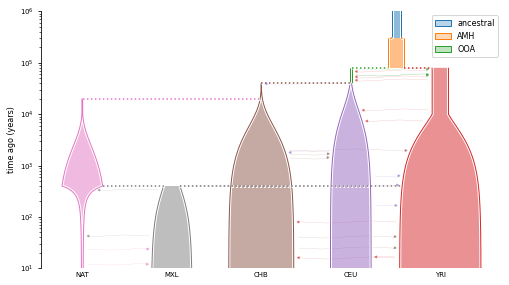

In [10]:
ax = demesdraw.tubes(mxl, num_lines_per_migration=3, log_time=True, seed=3, labels="xticks-legend");
ax.set_ylim(10, 1e6);

Note that these are just initial guesses! I don't know what the size history (especially for NAT), migration rates, and admixture proportions should be for this model - that's something we want to learn using ancestry tract distributions and the joint-SFS.

## A simple inference example

This is effectively a repeat of the demographic inference in the `moments` devel-branch documentation [here](https://moments.readthedocs.io/en/devel/extensions/demes.html#using-demes-to-infer-demography). This documentation page should be read before continuing.

Here we show an inference of the MSL (Mende from Sierra Leone) single-population size history using the SFS compiled from synonymous variants from the Phase 3 Thousand Genomes data (b37), which is largely a repeat of the previous documentation.

['MSL']


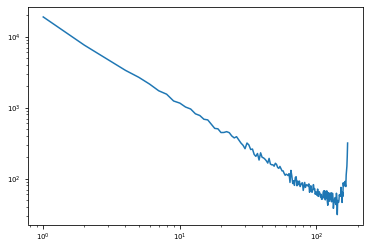

In [11]:
data = moments.Spectrum.from_file("msl_syn.fs")
print(data.pop_ids)
ax = plt.subplot(111)
ax.plot(data)
ax.set_yscale("log");
ax.set_xscale("log");

The parameterized demographic model we fit and the inference options are given in `MSL_guess.yaml` and `MSL_options.yaml`, resp. Let's first take a look at the initial guess model.

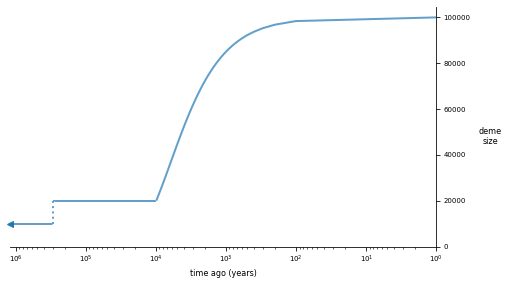

In [12]:
model = demes.load(open("../models/MSL_guess.yaml"))
ax = demesdraw.size_history(model, invert_x=True, log_time=True);

`moments.Demes` makes it very simple to fit this model to the data. We'll use the folded SFS, so that we are not biased by ancestral state mispolarization (which is apparent in the uptick in the high-frequency bins of the data SFS).

In [13]:
graph = "../models/MSL_guess.yaml"
options = "../models/MSL_options.yaml"
output = "../models/MSL_best_fit.yaml"
# verbose prints out updates, set to an integer > 0 to see
# progress of the optimization over the given intervals
verbose = 0
# I previously estimated the mutation rate (multiplied by coding length)
uL = 0.14419746897690008
ret = moments.Demes.Inference.optimize(
    graph, options, data.fold(), uL=uL, perturb=1,
    verbose=verbose, output=output, overwrite=True)
param_names, opt_params, LL = ret
print("Log-likelihood:", -LL)
print("Best fit parameters")
for n, p in zip(param_names, opt_params):
    print(f"{n}\t{p:.3}")

Log-likelihood: -371.94020593282676
Best fit parameters
T1	4.05e+05
T2	2.52e+04
Ne	1.12e+04
NA	2.54e+04
NF	6.19e+04


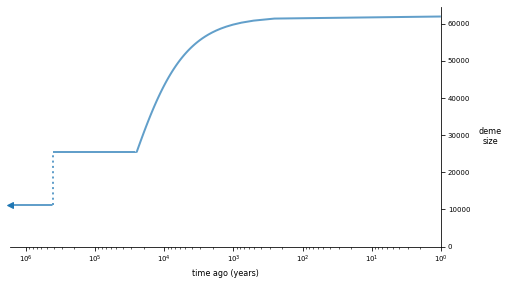

In [14]:
best_fit_model = demes.load(output)
ax = demesdraw.size_history(best_fit_model, invert_x=True, log_time=True);

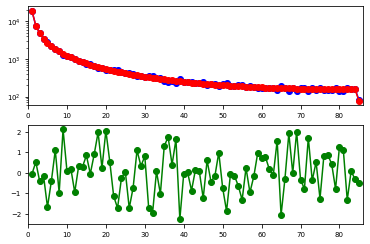

In [15]:
best_fit_fs = moments.Spectrum.from_demes(
    best_fit_model, ["MSL"], data.sample_sizes)
moments.Plotting.plot_1d_comp_multinom(best_fit_fs, data.fold(), show=False)
plt.gca().set_xlim([0, data.sample_sizes[0] / 2 + 1]);

The top panel is the model (red) fit to the data (blue), and the bottom panel shows residuals between the data and the model. This looks like a good fit to me!